In [1]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
import soundfile as sf
from scipy.io import wavfile
import scipy.signal
import numpy as np
import pylab
import wave
import tensorflow as tf

In [13]:
def pad_samples(samples, left, right):
    return numpy.pad(samples, (left, right), 'constant', constant_values=(samples[0], samples[-1]))

def get_linear_prediction_residues(samples):
    x = pad_samples(samples, 2, 0)
    y = pad_samples(samples, 1, 1)
    z = pad_samples(samples, 0, 2)

    residues = x + z - 2 * y
    return residues[:-2]

def cached(function):
    result = None
    def wrapped_function(self):
        if not hasattr(self, '__cache_' + function.__name__):
            setattr(self, '__cache_' + function.__name__, function(self))

        return getattr(self, '__cache_' + function.__name__)
    return wrapped_function

# TODO: time domain inputs and frequency domain inputs 
class TimeFrame:
    def __init__(self, offset, size, left_channel_samples, right_channel_samples):
        self._offset = offset
        self._size = size
        self._left_channel_samples = left_channel_samples
        self._right_channel_samples = right_channel_samples
    
    @property
    @cached
    def left_input(self):
        return self._left_channel_samples[self._offset: self._offset + self._size] * 0.5 + 0.5
    
    @property
    @cached
    def right_input(self):
        return self._right_channel_samples[self._offset: self._offset + self._size] * 0.5 + 0.5

    @property
    @cached
    def left_input_frequency_domain(self):
        return [x.real for x in numpy.fft.rfft(self.left_input)][1:]

    @property
    @cached
    def right_input_frequency_domain(self):
        return [x.real for x in numpy.fft.rfft(self.right_input)][1:]

    @property
    def time_input(self):
        return self._offset
    
    @property
    def left_output(self):
        return self._left_channel_samples[self._offset + self._size] * 0.5 + 0.5
    
    @property
    def right_output(self):
        return self._right_channel_samples[self._offset + self._size] * 0.5 + 0.5

def build_dataset(channel, size):
    left_channel_samples = pad_samples(channel.T[0], size, 0)
    right_channel_samples = pad_samples(channel.T[1], size, 0)
    return [TimeFrame(offset, size, left_channel_samples, right_channel_samples) for offset in range(channel.shape[0])]

<IPython.core.display.Javascript object>


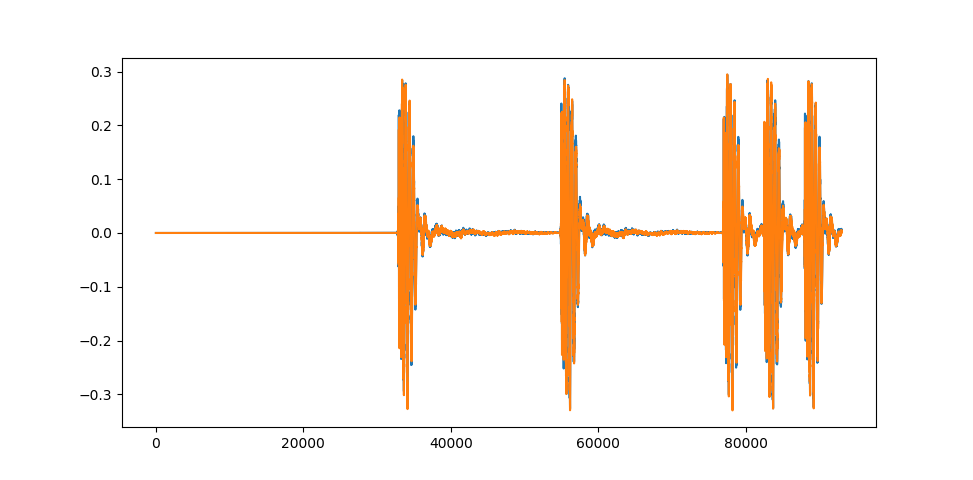

In [4]:
channel1_float, _ = sf.read('New Order - Blue Monday - Multitrack\\01 Blue Monday Drums 01.wav')
channel1_start = channel1_float[:93000]
plot(channel1_start);

In [5]:
#sprectrogram = scipy.signal.spectrogram(channel1_start.T[0], nperseg=4096, noverlap=4095, scaling='spectrum')

In [6]:
#plot(sprectrogram[2].T[60000][1:])

#import matplotlib.pyplot as plt

#plt.pcolormesh(sprectrogram[2])
#plt.ylabel('Frequency [Hz]')
#plt.xlabel('Time [sec]')
#plt.show()

#help(pcolormesh)

In [14]:
input_size = 2048

dataset = build_dataset(channel1_float, input_size)

In [18]:
import tensorflow as tf
import numpy
import matplotlib.pyplot as plt
import random

batch_size = 500
# input_size = 2048
output_size = 2
layer1_size = 2000
layer2_size = 1000
layer3_size = 500

num_steps = 100
learning_rate = 1e-5

graph = tf.Graph()

with graph.as_default():
  input = tf.placeholder(tf.float32, shape=(batch_size, input_size))
  output = tf.placeholder(tf.float32, shape=(batch_size, output_size))

  layer1_weights = tf.Variable(tf.random_normal((input_size, layer1_size), stddev=0.1))
  layer1_biases = tf.Variable(tf.constant(0.0, shape=(layer1_size,)))
  layer2_weights = tf.Variable(tf.random_normal((layer1_size, layer2_size), stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(0.0, shape=(layer2_size,)))
  layer3_weights = tf.Variable(tf.random_normal((layer2_size, layer3_size), stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(0.0, shape=(layer3_size,)))
  layer4_weights = tf.Variable(tf.random_normal((layer3_size, output_size), stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(0.0, shape=(output_size,)))

  # Model.
  def model(data):
    layer = tf.matmul(data, layer1_weights) + layer1_biases
    hidden = tf.nn.leaky_relu(layer)

    layer = tf.matmul(hidden, layer2_weights) + layer2_biases
    hidden = tf.nn.leaky_relu(layer)
    
    layer = tf.matmul(hidden, layer3_weights) + layer3_biases
    hidden = tf.nn.leaky_relu(layer)
    
    return tf.matmul(hidden, layer4_weights) + layer4_biases

  # Training computation.
  logits = model(input)
  #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=output, logits=logits))
  loss = tf.losses.mean_squared_error(output, logits)
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  #prediction = tf.nn.softmax(logits)
  prediction = logits

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    dataset_part = numpy.random.choice(dataset, size=batch_size)
    feed_dict = {
        input: [x.left_input for x in dataset_part],
        output: [[x.left_output, x.right_output] for x in dataset_part],
    }
    #_, l, predictions1 = session.run([optimizer, loss, prediction], feed_dict=feed_dict)
    _, l, predictions1 = session.run([optimizer, loss, logits], feed_dict=feed_dict)
    #if (step % 10 == 0):
    print('Minibatch loss at step %d: %f' % (step, l))

      #print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
  #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 1249.592163
Minibatch loss at step 1: 5069.156738
Minibatch loss at step 2: 12758.669922
Minibatch loss at step 3: 12810.698242
Minibatch loss at step 4: 1718.905884
Minibatch loss at step 5: 69.197502
Minibatch loss at step 6: 34.641533
Minibatch loss at step 7: 18.451254
Minibatch loss at step 8: 9.765368
Minibatch loss at step 9: 5.390006
Minibatch loss at step 10: 2.837765
Minibatch loss at step 11: 1.830468
Minibatch loss at step 12: 1.411581
Minibatch loss at step 13: 1.083518
Minibatch loss at step 14: 0.875615
Minibatch loss at step 15: 0.847357
Minibatch loss at step 16: 0.860897
Minibatch loss at step 17: 0.809682
Minibatch loss at step 18: 0.913834
Minibatch loss at step 19: 1.044317
Minibatch loss at step 20: 0.841572
Minibatch loss at step 21: 0.927055
Minibatch loss at step 22: 0.841661
Minibatch loss at step 23: 0.836854
Minibatch loss at step 24: 0.855506
Minibatch loss at step 25: 0.762941
Minibatch loss at step 26: 1.000337
Miniba

<IPython.core.display.Javascript object>


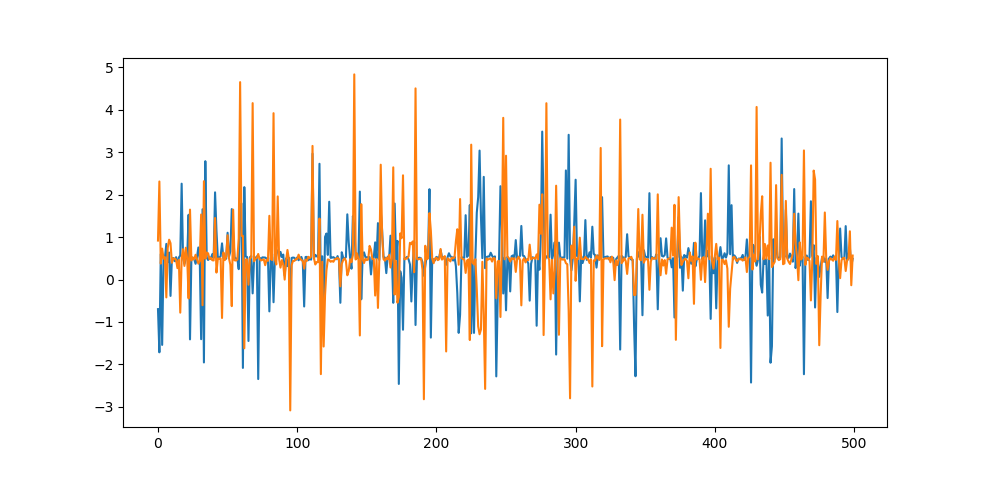

In [20]:
plot(predictions1);

In [ ]:
with tf.Session(graph=graph) as session: